# Risk Premia in REITs and its application in a quantitative value strategy

##### Dissertation for Master's degree in Economics from [Insper](https://www.insper.edu.br/en/graduate/masters-of-science/)

##### Advisor: [Prof. Dr. Gustavo B. Soares](https://github.com/gustavobsoares/) ([CV](http://lattes.cnpq.br/8491228979459078))
##### Student: Lucas L. Sanches ([Resume](http://lattes.cnpq.br/2528322802099316))

# Regressions Notebook

### Imports

In [1]:
from utils.database import *

In [2]:
from statsmodels.regression.rolling import RollingOLS
from linearmodels import LinearFactorModelGMM
import statsmodels.api as sm
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

### Complete period regressions

Assuming a non-arbitrage condition, the excess return expected for an asset $i$ should be proportional to its linear relationship with a set of factors $\gamma$, as below. To assess how many factors would be sufficient to explain the asset's return, the principal component analysis (PCA) technique can be used. 

$$R_i=\alpha+\beta_{i1}\gamma_1+...+\beta_{ik}\gamma_k$$

With this technique, it is observed that only two factors explain more than 80% of the variance of REIT returns. Therefore, two series should be sufficient as explanatory variables in the regressions that follow. Below, these two series will be representative of equity and fixed income returns, to explain REITs returns.

$$R^{REIT}_{t}=\alpha+\beta_1R^{Treasury}_{t}+\beta_2R^{SnP-500}_{t}$$

Besides, other regressions can be performed to evaluate the excess returns of real estate investment trusts in relation to classic risk factors in the literature:

$$R^{REIT}_{t}=\alpha+\beta_1MKT_{t}+\beta_2SMB_{t}+\beta_3HML_{t}+\beta_4RMW_{t}+\beta_5CMA_{t}+\beta_6MOM_{t}$$

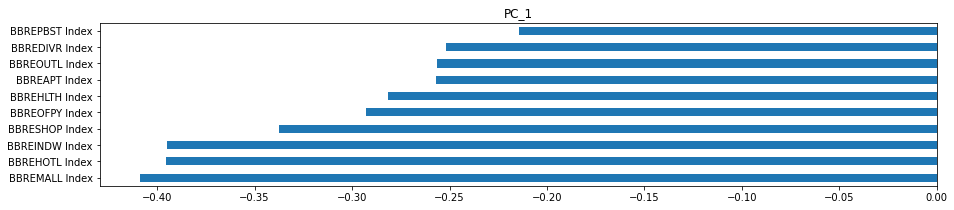

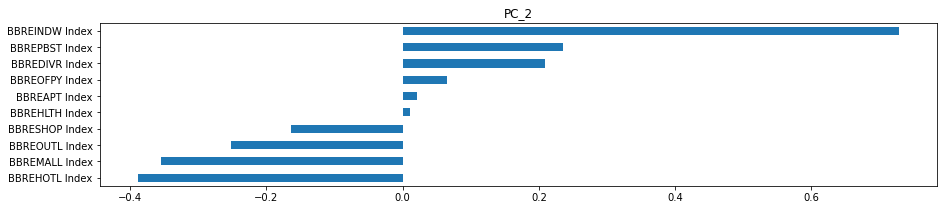

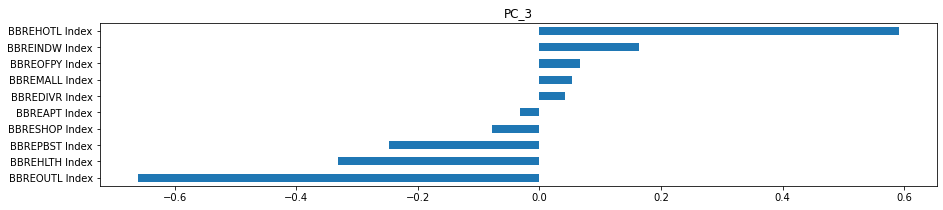

In [3]:
# PCA
cov = monthly_data[list(REITS.values())[:-1]].cov()
eig_vals, eig_vecs = np.linalg.eig(cov)

idx = eig_vals.argsort()[::-1]
eig_vals = eig_vals[idx]
eig_vecs = eig_vecs[:, idx]

pca_loadings = pd.DataFrame(index=cov.index,
                            columns=['PC_' + str(i) for i in range(1, cov.shape[1] + 1)],
                            data=eig_vecs).astype(float)
lambdas = eig_vals.astype(float)
pc_ts = (monthly_data[list(REITS.values())[:-1]][pca_loadings.index]@pca_loadings).astype(float)

for i in range(3):
    pca_loadings.iloc[:,i].sort_values().plot(kind='barh', figsize=(15,3))
    plt.title(pca_loadings.columns[i])
    plt.show()

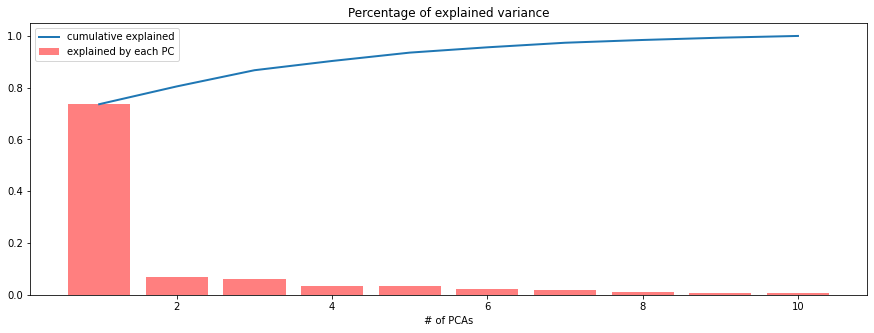

In [4]:
explained_variance = lambdas/lambdas.sum()
cumm_explained_variance = [explained_variance[0]]
for i in range(1,len(explained_variance)):
    cumm_explained_variance.append(cumm_explained_variance[i-1] + explained_variance[i])
plt.figure(figsize=(15, 5))
plt.plot(range(1,len(explained_variance)+1),cumm_explained_variance/np.sum(explained_variance), linewidth=2)
plt.bar(range(1,len(explained_variance)+1), explained_variance/np.sum(explained_variance), align='center', alpha=0.5, color='r')
plt.xlabel('# of PCAs')
plt.title('Percentage of explained variance')
plt.legend(['cumulative explained', 'explained by each PC'])
plt.show()

In [5]:
# Retrieving monthly returns starting all at same time
start_date = START_DATES['SPBDU1ST Index']
series = ['BBREIT Index', 'SPXFP Index', 'SPUSTTP Index', 'SPBDU1ST Index']
all_time_series = monthly_data.loc[monthly_data.index>start_date]

In [6]:
# Regression with only S&P 500
model = sm.OLS(all_time_series['BBREIT Index'],
               sm.add_constant(all_time_series['SPXFP Index'])).fit(cov_type='HAC',cov_kwds={'maxlags':3})  
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           BBREIT Index   R-squared:                       0.482
Model:                            OLS   Adj. R-squared:                  0.480
Method:                 Least Squares   F-statistic:                     44.77
Date:                Sat, 15 Jan 2022   Prob (F-statistic):           1.62e-10
Time:                        14:26:22   Log-Likelihood:                 396.04
No. Observations:                 236   AIC:                            -788.1
Df Residuals:                     234   BIC:                            -781.2
Df Model:                           1                                         
Covariance Type:                  HAC                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0010      0.003      0.313      0.754      -0.005       0.007
SPXFP Index     1.0143      0.152      6.691      0.000       0.717       1.311
==============================================================================
Omnibus:                       33.758   Durbin-Watson:                   2.205
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              119.958
Skew:                          -0.509   Prob(JB):                     8.94e-27
Kurtosis:                       6.341   Cond. No.                         23.3
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 3 lags and without small sample correction
"""

In [7]:
# Regression with S&P 500 and Treasury
model = sm.OLS(all_time_series['BBREIT Index'],
               sm.add_constant(all_time_series[['SPXFP Index','SPUSTTP Index']])).fit(cov_type='HAC',cov_kwds={'maxlags':3})  
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           BBREIT Index   R-squared:                       0.522
Model:                            OLS   Adj. R-squared:                  0.517
Method:                 Least Squares   F-statistic:                     53.31
Date:                Sat, 15 Jan 2022   Prob (F-statistic):           8.63e-20
Time:                        14:26:23   Log-Likelihood:                 405.42
No. Observations:                 236   AIC:                            -804.8
Df Residuals:                     233   BIC:                            -794.5
Df Model:                           2                                         
Covariance Type:                  HAC                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0021      0.003     -0.708      0.479      -0.008       0.004
SPXFP Index       1.1101      0.126      8.828      0.000       0.864       1.357
SPUSTTP Index     0.7906      0.254      3.112      0.002       0.293       1.289
==============================================================================
Omnibus:                       54.153   Durbin-Watson:                   2.186
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              349.210
Skew:                          -0.685   Prob(JB):                     1.48e-76
Kurtosis:                       8.799   Cond. No.                         63.9
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 3 lags and without small sample correction
"""

In [8]:
# Regression with S&P 500, Treasury and TIPS
model = sm.OLS(all_time_series['BBREIT Index'],
               sm.add_constant(all_time_series[['SPXFP Index','SPUSTTP Index', 'SPBDU1ST Index']])).fit(cov_type='HAC',cov_kwds={'maxlags':3})  
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           BBREIT Index   R-squared:                       0.527
Model:                            OLS   Adj. R-squared:                  0.521
Method:                 Least Squares   F-statistic:                     36.28
Date:                Sat, 15 Jan 2022   Prob (F-statistic):           2.91e-19
Time:                        14:26:23   Log-Likelihood:                 406.85
No. Observations:                 236   AIC:                            -805.7
Df Residuals:                     232   BIC:                            -791.8
Df Model:                           3                                         
Covariance Type:                  HAC                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0025      0.003     -0.840      0.401      -0.008       0.003
SPXFP Index        1.0549      0.127      8.302      0.000       0.806       1.304
SPUSTTP Index      0.3744      0.467      0.802      0.423      -0.541       1.290
SPBDU1ST Index     0.4345      0.348      1.248      0.212      -0.248       1.117
==============================================================================
Omnibus:                       43.685   Durbin-Watson:                   2.225
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              262.802
Skew:                          -0.504   Prob(JB):                     8.57e-58
Kurtosis:                       8.070   Cond. No.                         135.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 3 lags and without small sample correction
"""

In [9]:
# Regression with S&P 500 and TIPS
model = sm.OLS(all_time_series['BBREIT Index'],
               sm.add_constant(all_time_series[['SPXFP Index', 'SPBDU1ST Index']])).fit(cov_type='HAC',cov_kwds={'maxlags':3})  
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           BBREIT Index   R-squared:                       0.524
Model:                            OLS   Adj. R-squared:                  0.520
Method:                 Least Squares   F-statistic:                     51.30
Date:                Sat, 15 Jan 2022   Prob (F-statistic):           3.46e-19
Time:                        14:26:24   Log-Likelihood:                 406.09
No. Observations:                 236   AIC:                            -806.2
Df Residuals:                     233   BIC:                            -795.8
Df Model:                           2                                         
Covariance Type:                  HAC                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0022      0.003     -0.749      0.454      -0.008       0.004
SPXFP Index        1.0068      0.128      7.874      0.000       0.756       1.257
SPBDU1ST Index     0.6910      0.179      3.863      0.000       0.340       1.042
==============================================================================
Omnibus:                       34.830   Durbin-Watson:                   2.249
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              177.885
Skew:                          -0.376   Prob(JB):                     2.36e-39
Kurtosis:                       7.186   Cond. No.                         53.5
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 3 lags and without small sample correction
"""

In [10]:
# Retrieving monthly returns for factor starting all at same time as previously
all_time_series_ff = all_time_series.iloc[:-2].copy()
all_time_series_ff.loc[:,'MKT'] = ff_factors.loc['200201':]['Mkt-RF'].values
all_time_series_ff.loc[:,'SMB'] = ff_factors.loc['200201':]['SMB'].values
all_time_series_ff.loc[:,'HML'] = ff_factors.loc['200201':]['HML'].values
all_time_series_ff.loc[:,'RMW'] = ff_factors.loc['200201':]['RMW'].values
all_time_series_ff.loc[:,'CMA'] = ff_factors.loc['200201':]['CMA'].values
all_time_series_ff.loc[:,'MOM'] = ff_factors.loc['200201':]['Mom'].values

In [11]:
# Regression with Fama-French Factors
model = sm.OLS(all_time_series_ff['BBREIT Index'],
               sm.add_constant(all_time_series_ff[['MKT', 'SMB', 'HML', 'RMW', 'CMA', 'MOM']])).fit(cov_type='HAC',cov_kwds={'maxlags':3})  
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           BBREIT Index   R-squared:                       0.527
Model:                            OLS   Adj. R-squared:                  0.515
Method:                 Least Squares   F-statistic:                     17.28
Date:                Sat, 15 Jan 2022   Prob (F-statistic):           1.95e-16
Time:                        14:26:27   Log-Likelihood:                 402.54
No. Observations:                 234   AIC:                            -791.1
Df Residuals:                     227   BIC:                            -766.9
Df Model:                           6                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.003     -0.127      0.899      -0.006       0.005
MKT            0.8864      0.107      8.319      0.000       0.678       1.095
SMB            0.2402      0.136      1.772      0.076      -0.025       0.506
HML            0.4600      0.206      2.237      0.025       0.057       0.863
RMW            0.1497      0.198      0.757      0.449      -0.238       0.537
CMA           -0.1826      0.284     -0.642      0.521      -0.740       0.375
MOM           -0.0269      0.107     -0.251      0.801      -0.237       0.183
==============================================================================
Omnibus:                       35.206   Durbin-Watson:                   2.184
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               89.057
Skew:                          -0.668   Prob(JB):                     4.59e-20
Kurtosis:                       5.711   Cond. No.                         75.8
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 3 lags and without small sample correction
"""

#### Complete period regressions (by REIT sector)

In [12]:
# Regression with only S&P 500
sector_betas = pd.DataFrame()
sector_betas_pvalues = pd.DataFrame()
for sector in list(REITS.values())[:-1]:
    model = sm.OLS(all_time_series[sector],
                   sm.add_constant(all_time_series[['SPXFP Index']])).fit(cov_type='HAC',cov_kwds={'maxlags':3})  
    sector_name = list(REITS.keys())[list(REITS.values()).index(sector)] 
    sector_betas = sector_betas.append(model.params.to_frame(sector_name).T)
    sector_betas_pvalues = sector_betas_pvalues.append(model.pvalues.to_frame(sector_name).T)
print("Betas: \n",sector_betas)
print("\np-values: \n",sector_betas_pvalues)

Betas: 
                    const  SPXFP Index
Industrial     -0.001276     1.421658
Diversified     0.001296     0.957586
Self storage    0.008292     0.558705
Single tenant   0.008217     0.761674
Healthcare      0.002756     0.860671
Apartment       0.002199     0.930180
Office         -0.002390     1.089713
Shopping       -0.001921     1.155090
Hotel          -0.007410     1.655279
Regional Malls -0.002414     1.407110

p-values: 
                    const   SPXFP Index
Industrial      0.832820  1.803511e-04
Diversified     0.672759  5.205421e-11
Self storage    0.014906  3.334125e-05
Single tenant   0.075370  8.026449e-07
Healthcare      0.482329  1.381063e-08
Apartment       0.536147  3.881125e-12
Office          0.465706  4.070579e-14
Shopping        0.662592  2.300499e-09
Hotel           0.084089  9.975062e-19
Regional Malls  0.702950  5.522413e-07


In [13]:
# Regression with S&P 500 and Treasury
sector_betas = pd.DataFrame()
sector_betas_pvalues = pd.DataFrame()
for sector in list(REITS.values())[:-1]:
    model = sm.OLS(all_time_series[sector],
                   sm.add_constant(all_time_series[['SPXFP Index', 'SPUSTTP Index']])).fit(cov_type='HAC',cov_kwds={'maxlags':3})  
    sector_name = list(REITS.keys())[list(REITS.values()).index(sector)] 
    sector_betas = sector_betas.append(model.params.to_frame(sector_name).T)
    sector_betas_pvalues = sector_betas_pvalues.append(model.pvalues.to_frame(sector_name).T)
print("Betas: \n",sector_betas)
print("\np-values: \n",sector_betas_pvalues)

Betas: 
                    const  SPXFP Index  SPUSTTP Index
Industrial     -0.006475     1.585356       1.350788
Diversified    -0.001700     1.051921       0.778428
Self storage    0.004681     0.672423       0.938370
Single tenant   0.003195     0.919824       1.305013
Healthcare     -0.001309     0.988687       1.056357
Apartment      -0.000057     1.001194       0.585989
Office         -0.004629     1.160207       0.581695
Shopping       -0.005337     1.262648       0.887536
Hotel          -0.007609     1.661557       0.051803
Regional Malls -0.004617     1.476488       0.572492

p-values: 
                    const   SPXFP Index  SPUSTTP Index
Industrial      0.273596  1.220791e-05       0.004053
Diversified     0.533931  6.361256e-19       0.001973
Self storage    0.197627  7.606758e-08       0.000539
Single tenant   0.476097  5.453644e-11       0.000681
Healthcare      0.734776  1.772492e-14       0.004392
Apartment       0.986980  7.104824e-17       0.009909
Office          0

In [14]:
# Regression with S&P 500, Treasury and TIPS
sector_betas = pd.DataFrame()
sector_betas_pvalues = pd.DataFrame()
for sector in list(REITS.values())[:-1]:
    model = sm.OLS(all_time_series[sector],
                   sm.add_constant(all_time_series[['SPXFP Index', 'SPUSTTP Index', 'SPBDU1ST Index']])).fit(cov_type='HAC',cov_kwds={'maxlags':3})  
    sector_name = list(REITS.keys())[list(REITS.values()).index(sector)] 
    sector_betas = sector_betas.append(model.params.to_frame(sector_name).T)
    sector_betas_pvalues = sector_betas_pvalues.append(model.pvalues.to_frame(sector_name).T)
print("Betas: \n",sector_betas)
print("\np-values: \n",sector_betas_pvalues)

Betas: 
                    const  SPXFP Index  SPUSTTP Index  SPBDU1ST Index
Industrial     -0.007600     1.431143       0.186942        1.214983
Diversified    -0.002136     0.992118       0.327097        0.471161
Self storage    0.004816     0.690970       1.078347       -0.146127
Single tenant   0.002727     0.855708       0.821125        0.505149
Healthcare     -0.001653     0.941613       0.701082        0.370884
Apartment      -0.000415     0.952066       0.215219        0.387061
Office         -0.004724     1.147179       0.483372        0.102643
Shopping       -0.005692     1.214092       0.521079        0.382558
Hotel          -0.007934     1.617024      -0.284285        0.350855
Regional Malls -0.005622     1.338790      -0.466718        1.084870

p-values: 
                    const   SPXFP Index  SPUSTTP Index  SPBDU1ST Index
Industrial      0.207257  2.902539e-06       0.863646        0.160185
Diversified     0.447149  5.840893e-18       0.444096        0.138253
Self stor

In [15]:
# Regression with S&P 500 and TIPS
sector_betas = pd.DataFrame()
sector_betas_pvalues = pd.DataFrame()
for sector in list(REITS.values())[:-1]:
    model = sm.OLS(all_time_series[sector],
                   sm.add_constant(all_time_series[['SPXFP Index', 'SPBDU1ST Index']])).fit(cov_type='HAC',cov_kwds={'maxlags':3})  
    sector_name = list(REITS.keys())[list(REITS.values()).index(sector)] 
    sector_betas = sector_betas.append(model.params.to_frame(sector_name).T)
    sector_betas_pvalues = sector_betas_pvalues.append(model.pvalues.to_frame(sector_name).T)
print("Betas: \n",sector_betas)
print("\np-values: \n",sector_betas_pvalues)

Betas: 
                    const  SPXFP Index  SPBDU1ST Index
Industrial     -0.007471     1.407100        1.343033
Diversified    -0.001911     0.950050        0.695215
Self storage    0.005559     0.552283        0.592514
Single tenant   0.003293     0.750102        1.067599
Healthcare     -0.001170     0.851445        0.851108
Apartment      -0.000267     0.924387        0.534481
Office         -0.004391     1.085012        0.433741
Shopping       -0.005333     1.147075        0.739485
Hotel          -0.008130     1.653587        0.156127
Regional Malls -0.005943     1.398815        0.765180

p-values: 
                    const   SPXFP Index  SPBDU1ST Index
Industrial      0.234586  1.679511e-05        0.000320
Diversified     0.509280  2.611263e-14        0.000124
Self storage    0.111658  5.712990e-06        0.004404
Single tenant   0.485091  1.893823e-07        0.000347
Healthcare      0.778493  4.207777e-10        0.001129
Apartment       0.940058  5.131041e-15        0.003506

In [16]:
# Correlations between independent variables
all_time_series[['SPXFP Index', 'SPUSTTP Index', 'SPBDU1ST Index']].corr()

,SPXFP Index,SPUSTTP Index,SPBDU1ST Index
SPXFP Index,1.000000,-0.313118,0.02493
SPUSTTP Index,-0.313118,1.000000,0.76125
SPBDU1ST Index,0.024930,0.761250,1.00000


#### Complete period regressions (Fama-MacBeth)

In [17]:
fama_macbeth = all_time_series[list(REITS.values())[:-1]].stack().rename('return')
fama_macbeth.index.set_names(['date','sector'], inplace=True)
fama_macbeth.reset_index().set_index(['sector','date'], inplace=True)
fama_macbeth = pd.DataFrame(fama_macbeth)
fama_macbeth['SPXFP Index'] = pd.Series(dtype=float)
fama_macbeth['SPUSTTP Index'] = pd.Series(dtype=float)
fama_macbeth['SPBDU1ST Index'] = pd.Series(dtype=float)
for i in all_time_series.index.values:
    fama_macbeth.loc[i,'SPXFP Index'] = all_time_series.loc[i,'SPXFP Index']
    fama_macbeth.loc[i,'SPUSTTP Index'] = all_time_series.loc[i,'SPUSTTP Index']
    fama_macbeth.loc[i,'SPBDU1ST Index'] = all_time_series.loc[i,'SPBDU1ST Index']
fama_macbeth

return  SPXFP Index  SPUSTTP Index  \
date       sector                                                 
2002-01-31 BBREINDW Index -0.003515    -0.016405       0.012780   
           BBREDIVR Index  0.019984    -0.016405       0.012780   
           BBREPBST Index  0.064771    -0.016405       0.012780   
           BBREOUTL Index  0.038095    -0.016405       0.012780   
           BBREHLTH Index  0.073060    -0.016405       0.012780   
...                             ...          ...            ...   
2021-08-31 BBREAPT Index   0.007813     0.029409      -0.002106   
           BBREOFPY Index -0.017354     0.029409      -0.002106   
           BBRESHOP Index  0.032212     0.029409      -0.002106   
           BBREHOTL Index  0.032325     0.029409      -0.002106   
           BBREMALL Index  0.065235     0.029409      -0.002106   

                           SPBDU1ST Index  
date       sector                          
2002-01-31 BBREINDW Index        0.008583  
           BBREDIVR Index        0.008583  
           BBREPBST Index        0.008583  
           BBREOUTL Index        0.008583  
           BBREHLTH Index        0.008583  
...                                   ...  
2021-08-31 BBREAPT Index        -0.004557  
           BBREOFPY Index       -0.004557  
           BBRESHOP Index       -0.004557  
           BBREHOTL Index       -0.004557  
           BBREMALL Index       -0.004557  

[2360 rows x 4 columns]

In [18]:
# Regression with only S&P 500
betas = pd.DataFrame()
pvalues = pd.DataFrame()
for t in fama_macbeth.index.get_level_values(0).unique():
    yt = fama_macbeth.loc[t].iloc[:,[0]]
    xt = fama_macbeth.loc[t].iloc[:,[1]]
    model = sm.OLS(yt, sm.add_constant(xt)).fit(cov_type='HC3')
    betas = betas.append(model.params.to_frame(t).T)
print("Betas: \n", betas.describe())
print("\np-values: \n", stats.t.sf(np.abs((betas.mean()/(betas.std()/np.sqrt(betas.count())))), len(betas)-1)*2)

Betas: 
        SPXFP Index
count   236.000000
mean      2.093572
std      14.723021
min     -64.745788
25%      -0.147617
50%       0.973315
75%       1.916022
max     160.769278

p-values: 
 [0.02991622]


In [19]:
# Regression with S&P 500 and Treasury
betas = pd.DataFrame()
pvalues = pd.DataFrame()
for t in fama_macbeth.index.get_level_values(0).unique():
    yt = fama_macbeth.loc[t].iloc[:,[0]]
    xt = fama_macbeth.loc[t].iloc[:,[1,2]]
    model = sm.OLS(yt, sm.add_constant(xt)).fit(cov_type='HC3')
    betas = betas.append(model.params.to_frame(t).T)
print("Betas: \n", betas.describe())
print("\np-values: \n", stats.t.sf(np.abs((betas.mean()/(betas.std()/np.sqrt(betas.count())))), len(betas)-1)*2)

Betas: 
        SPXFP Index  SPUSTTP Index
count   236.000000     236.000000
mean      1.279175       0.756801
std       8.256997       6.052654
min     -18.336236      -8.100841
25%      -0.077547      -0.168491
50%       0.723187       0.077883
75%       1.328946       0.559872
max     109.321630      74.995605

p-values: 
 [0.01811489 0.05596159]


In [20]:
# Regression with S&P 500, Treasury and TIPS
betas = pd.DataFrame()
pvalues = pd.DataFrame()
for t in fama_macbeth.index.get_level_values(0).unique():
    yt = fama_macbeth.loc[t].iloc[:,[0]]
    xt = fama_macbeth.loc[t].iloc[:,[1,2,3]]
    model = sm.OLS(yt, sm.add_constant(xt)).fit(cov_type='HC3')
    betas = betas.append(model.params.to_frame(t).T)
print("Betas: \n", betas.describe())
print("\np-values: \n", stats.t.sf(np.abs((betas.mean()/(betas.std()/np.sqrt(betas.count())))), len(betas)-1)*2)

Betas: 
        SPXFP Index  SPUSTTP Index  SPBDU1ST Index
count   236.000000     236.000000      236.000000
mean      0.529979       0.151262        0.227703
std       1.150591       0.730594        1.339236
min      -6.170345      -3.098131       -3.021259
25%      -0.060208      -0.146760       -0.122635
50%       0.548771       0.071081        0.061949
75%       1.040388       0.321351        0.454922
max       5.372613       4.843967       10.856898

p-values: 
 [1.69390117e-11 1.66763787e-03 9.58235359e-03]


In [21]:
# Regression with S&P 500 and TIPS
betas = pd.DataFrame()
pvalues = pd.DataFrame()
for t in fama_macbeth.index.get_level_values(0).unique():
    yt = fama_macbeth.loc[t].iloc[:,[0]]
    xt = fama_macbeth.loc[t].iloc[:,[1,3]]
    model = sm.OLS(yt, sm.add_constant(xt)).fit(cov_type='HC3')
    betas = betas.append(model.params.to_frame(t).T)
print("Betas: \n", betas.describe())
print("\np-values: \n", stats.t.sf(np.abs((betas.mean()/(betas.std()/np.sqrt(betas.count())))), len(betas)-1)*2)

Betas: 
        SPXFP Index  SPBDU1ST Index
count   236.000000      236.000000
mean      0.588550        0.301961
std       1.380096        1.626017
min      -6.285109       -4.793686
25%      -0.079303       -0.166496
50%       0.652702        0.067259
75%       1.157855        0.564625
max       6.620343       11.910549

p-values: 
 [3.56406326e-10 4.71893463e-03]


#### Complete period regressions (Generalized Method of Moments)

The Fama–MacBeth estimator ignores the estimation error present in betas and suffers from the so-called errors-in-variable (EIV) problem. In addition, it does not account for the returns and factors potentially being serially correlated.

Feasible Generalized Least Squares (FGLS) is normally used nowadays since the Fama–MacBeth estimator ignores the estimation error in betas as well as potential serial correlation in returns. In the first step, we estimate factor loadings by regressing the excess returns on the factors (augmented with a constant). In the second step, we use the factor loadings to estimate the risk premia with the dependent variable as the average excess return. The standard here is: first step to get an consistent estimate of the covariance of the moment conditions and the second step to efficiently estimate parameters.

In [22]:
# Regression with only S&P 500
model = LinearFactorModelGMM(all_time_series[list(REITS.values())[:-1]],
                             all_time_series[['SPXFP Index']]).fit(cov_type="kernel")
print("Betas: \n", model.params)
pvalues = model.params.copy()
pvalues.loc[:,:] = (stats.t.sf(np.abs(model.tstats), len(all_time_series)-1)*2)
print("\np-values: \n", pvalues)

Iteration: 0, Objective: 36.43591239884692
Iteration: 10, Objective: 29.936663237295917
         Current function value: 29.338999
         Iterations: 20
         Function evaluations: 1143
         Gradient evaluations: 87
Iteration: 0, Objective: 29.387818421818658
Iteration: 10, Objective: 29.323023675822338
Optimization terminated successfully.
         Current function value: 29.291220
         Iterations: 18
         Function evaluations: 312
         Gradient evaluations: 24
Betas: 
                    alpha  SPXFP Index
BBREINDW Index  0.004581     1.361013
BBREDIVR Index  0.005210     0.932285
BBREPBST Index  0.010572     0.546056
BBREOUTL Index  0.011240     0.787584
BBREHLTH Index  0.006271     0.839644
BBREAPT Index   0.005947     0.932956
BBREOFPY Index  0.002040     1.073027
BBRESHOP Index  0.002824     1.112395
BBREHOTL Index -0.000715     1.647144
BBREMALL Index  0.003430     1.323172

p-values: 
                    alpha    SPXFP Index
BBREINDW Index  0.405323   0.000

In [23]:
# Regression with S&P 500 and Treasury
model = LinearFactorModelGMM(all_time_series[list(REITS.values())[:-1]],
                             all_time_series[['SPXFP Index', 'SPUSTTP Index']]).fit(cov_type="kernel")
print("Betas: \n", model.params)
pvalues = model.params.copy()
pvalues.loc[:,:] = (stats.t.sf(np.abs(model.tstats), len(all_time_series)-1)*2)
print("\np-values: \n", pvalues)

Iteration: 0, Objective: 48.682173917422986
Iteration: 10, Objective: 29.914141732399244
Iteration: 20, Objective: 24.150063764665617
Iteration: 30, Objective: 16.126059700616278
         Current function value: 16.125683
         Iterations: 39
         Function evaluations: 2012
         Gradient evaluations: 80
Iteration: 0, Objective: 16.236163679496105
Iteration: 10, Objective: 15.785153268816083
Iteration: 20, Objective: 15.596622974519276
Iteration: 30, Objective: 15.402672466365553
         Current function value: 15.402672
         Iterations: 31
         Function evaluations: 2112
         Gradient evaluations: 84
Betas: 
                    alpha  SPXFP Index  SPUSTTP Index
BBREINDW Index  0.001226     1.457332       1.290191
BBREDIVR Index  0.003978     0.931559       0.746951
BBREPBST Index  0.003375     0.571336       1.087838
BBREOUTL Index  0.004250     1.001828       1.319603
BBREHLTH Index  0.001914     1.027642       1.082578
BBREAPT Index   0.006067     0.916412    

In [24]:
# Regression with S&P 500, Treasury and TIPS
model = LinearFactorModelGMM(all_time_series[list(REITS.values())[:-1]],
                             all_time_series[['SPXFP Index', 'SPUSTTP Index', 'SPBDU1ST Index']]).fit(cov_type="kernel")
print("Betas: \n", model.params)
pvalues = model.params.copy()
pvalues.loc[:,:] = (stats.t.sf(np.abs(model.tstats), len(all_time_series)-1)*2)
print("\np-values: \n", pvalues)

Iteration: 0, Objective: 98.70525396021566
Iteration: 10, Objective: 44.600241999817385
Iteration: 20, Objective: 34.49592810501441
Iteration: 30, Objective: 23.17094513670062
Iteration: 40, Objective: 17.295133551789778
Iteration: 50, Objective: 17.239866778243016
Iteration: 60, Objective: 17.23986677216483
Iteration: 70, Objective: 17.239866772079665
         Current function value: 17.239867
         Iterations: 72
         Function evaluations: 7153
         Gradient evaluations: 193
Iteration: 0, Objective: 19.9191586421324
Iteration: 10, Objective: 17.48255651845221
Iteration: 20, Objective: 16.54657671974216
Iteration: 30, Objective: 15.770405956269617
Iteration: 40, Objective: 15.22359677236624
         Current function value: 15.223596
         Iterations: 44
         Function evaluations: 3156
         Gradient evaluations: 85
Betas: 
                    alpha  SPXFP Index  SPUSTTP Index  SPBDU1ST Index
BBREINDW Index  0.001600     1.321667      -0.193903        1.489532
BBRE

In [25]:
# Regression with S&P 500 and TIPS
model = LinearFactorModelGMM(all_time_series[list(REITS.values())[:-1]],
                             all_time_series[['SPXFP Index', 'SPBDU1ST Index']]).fit(cov_type="kernel")
print("Betas: \n", model.params)
pvalues = model.params.copy()
pvalues.loc[:,:] = (stats.t.sf(np.abs(model.tstats), len(all_time_series)-1)*2)
print("\np-values: \n", pvalues)

Iteration: 0, Objective: 107.9375259741802
Iteration: 10, Objective: 70.17917386150292
Iteration: 20, Objective: 51.348038853830175
Iteration: 30, Objective: 24.302243309107446
Iteration: 40, Objective: 24.21915736669095
         Current function value: 24.219157
         Iterations: 45
         Function evaluations: 2812
         Gradient evaluations: 112
Iteration: 0, Objective: 37.47043367059471
Iteration: 10, Objective: 29.70239318514372
Iteration: 20, Objective: 27.78260600681064
Iteration: 30, Objective: 23.95592864934616
         Current function value: 23.955929
         Iterations: 33
         Function evaluations: 2191
         Gradient evaluations: 87
Betas: 
                    alpha  SPXFP Index  SPBDU1ST Index
BBREINDW Index  0.000341     1.012120        0.964702
BBREDIVR Index  0.003336     0.761036        0.615079
BBREPBST Index  0.005257     0.380735        0.642458
BBREOUTL Index  0.005551     0.745307        0.868497
BBREHLTH Index  0.000831     0.835320        0.898

### Rolling regressions

The hypothesis of a constant linear coefficient over so many years seems to have little validity in reality, intuitively and under the light of the literature. Therefore, the previous regressions were estimated allowing the variation of the coefficients over time, using sliding windows of 12 and 36 months.

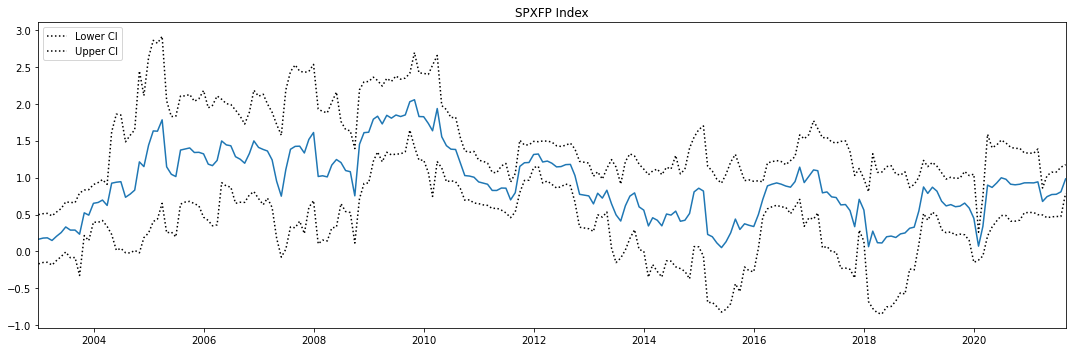

In [26]:
# Regression with only S&P 500
model = RollingOLS(all_time_series['BBREIT Index'],
                   all_time_series[['SPXFP Index']], window=12).fit(cov_type='HAC',cov_kwds={'maxlags':3})
fig = model.plot_recursive_coefficient(figsize=(15,5))

<AxesSubplot:>

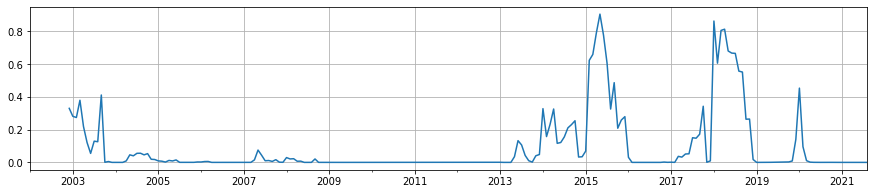

In [27]:
pd.Series([i[0] for i in list(model.pvalues)], index=model.rsquared_adj.index).plot(figsize=(15,3), grid=True)

<AxesSubplot:>

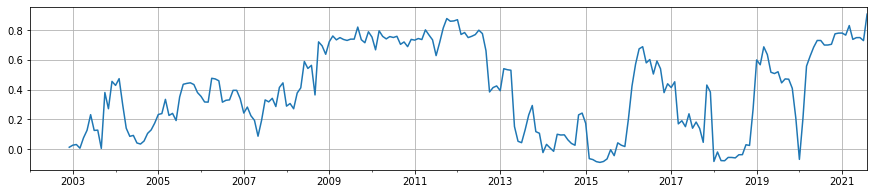

In [28]:
model.rsquared_adj.plot(figsize=(15,3), grid=True)

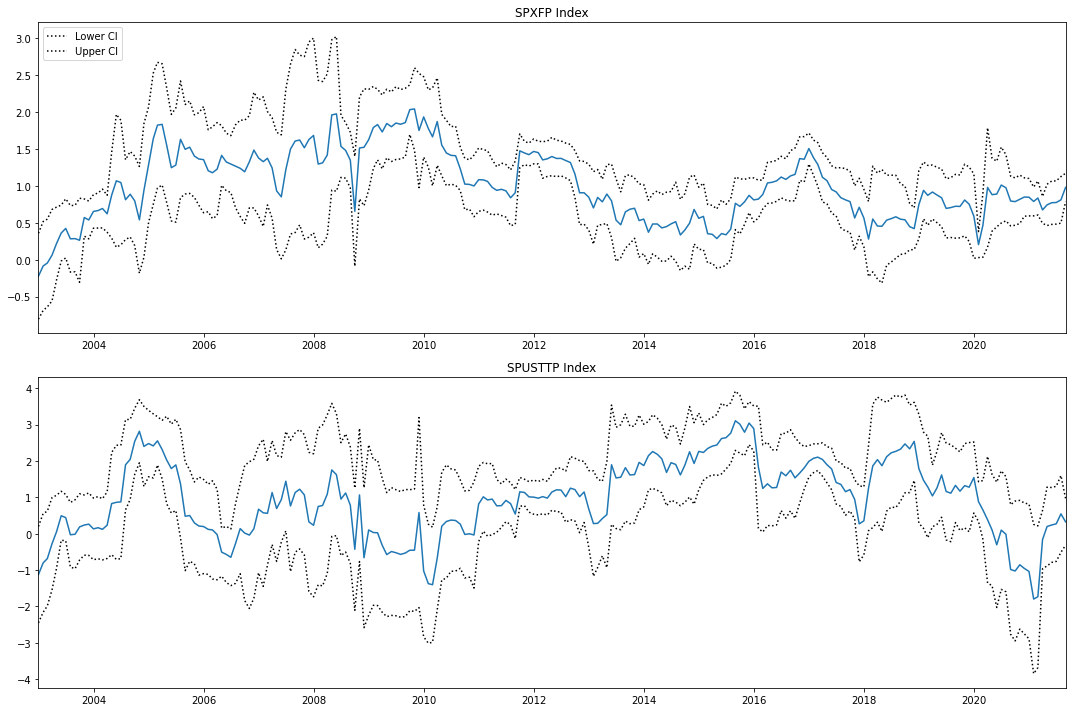

In [29]:
# Regression with S&P 500 and Treasury
model = RollingOLS(all_time_series['BBREIT Index'],
                   all_time_series[['SPXFP Index', 'SPUSTTP Index']],
                   window=12).fit(cov_type='HAC',cov_kwds={'maxlags':3})
fig = model.plot_recursive_coefficient(figsize=(15,10))

<AxesSubplot:>

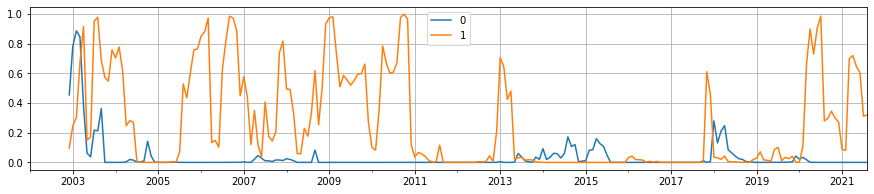

In [30]:
pd.DataFrame(model.pvalues, index=model.rsquared_adj.index).plot(figsize=(15,3), grid=True)

<AxesSubplot:>

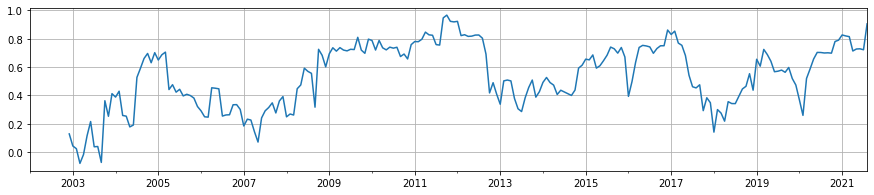

In [31]:
model.rsquared_adj.plot(figsize=(15,3), grid=True)

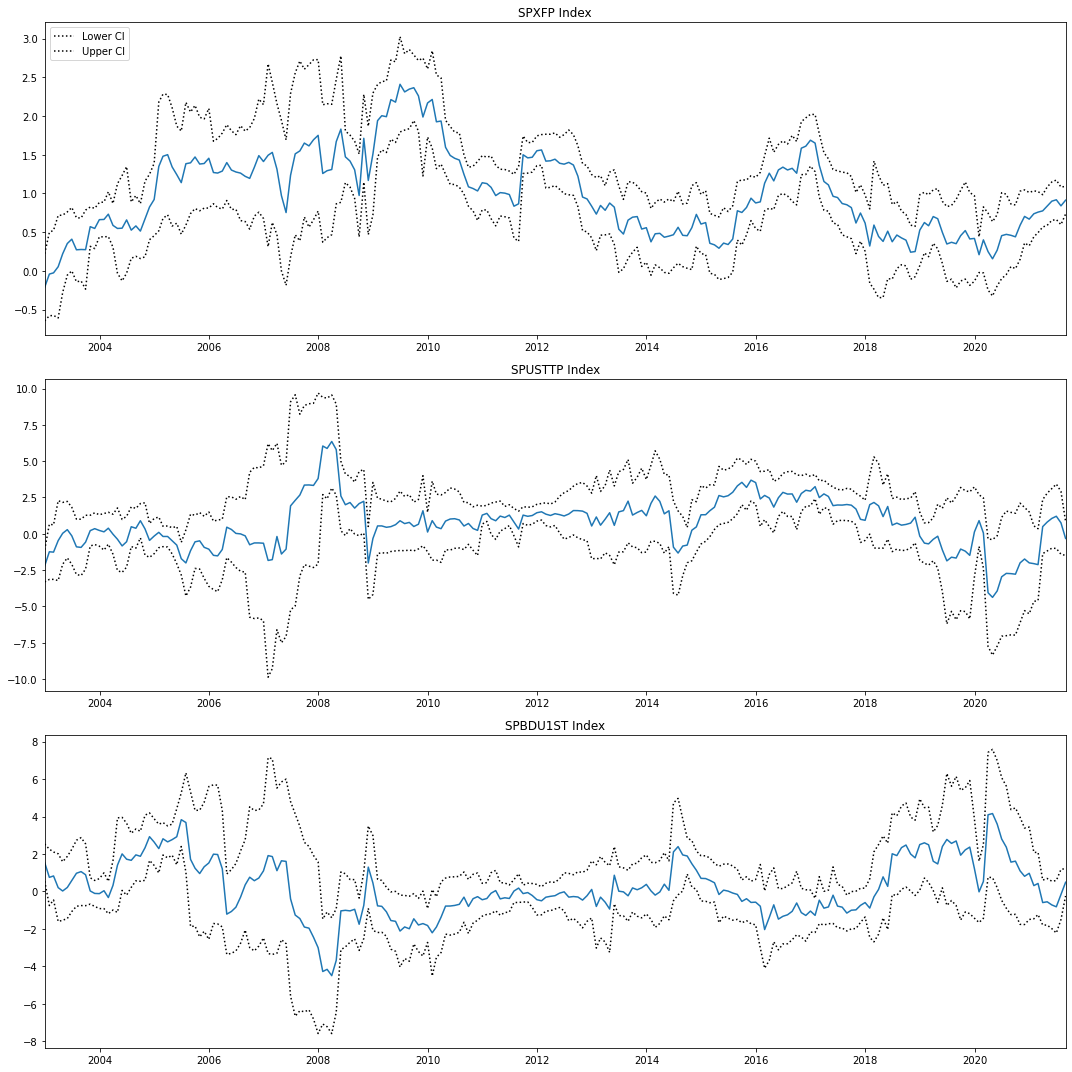

In [32]:
# Regression with S&P 500, Treasury and TIPS
model = RollingOLS(all_time_series['BBREIT Index'],
                   all_time_series[['SPXFP Index', 'SPUSTTP Index', 'SPBDU1ST Index']],
                   window=12).fit(cov_type='HAC',cov_kwds={'maxlags':3})
fig = model.plot_recursive_coefficient(figsize=(15,15))

<AxesSubplot:>

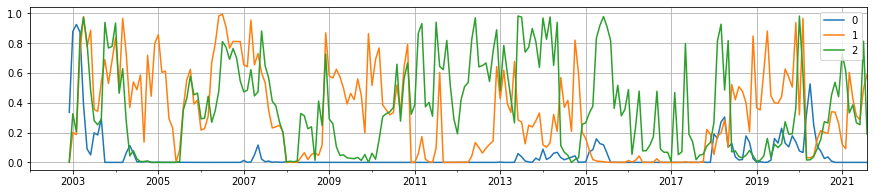

In [33]:
pd.DataFrame(model.pvalues, index=model.rsquared_adj.index).plot(figsize=(15,3), grid=True)

<AxesSubplot:>

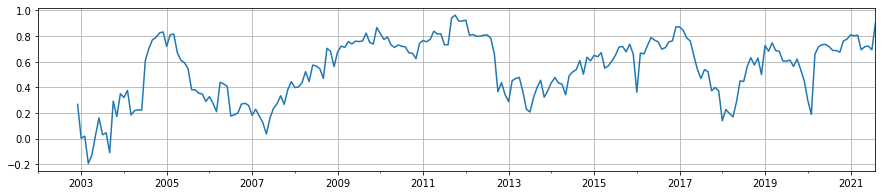

In [34]:
model.rsquared_adj.plot(figsize=(15,3), grid=True)

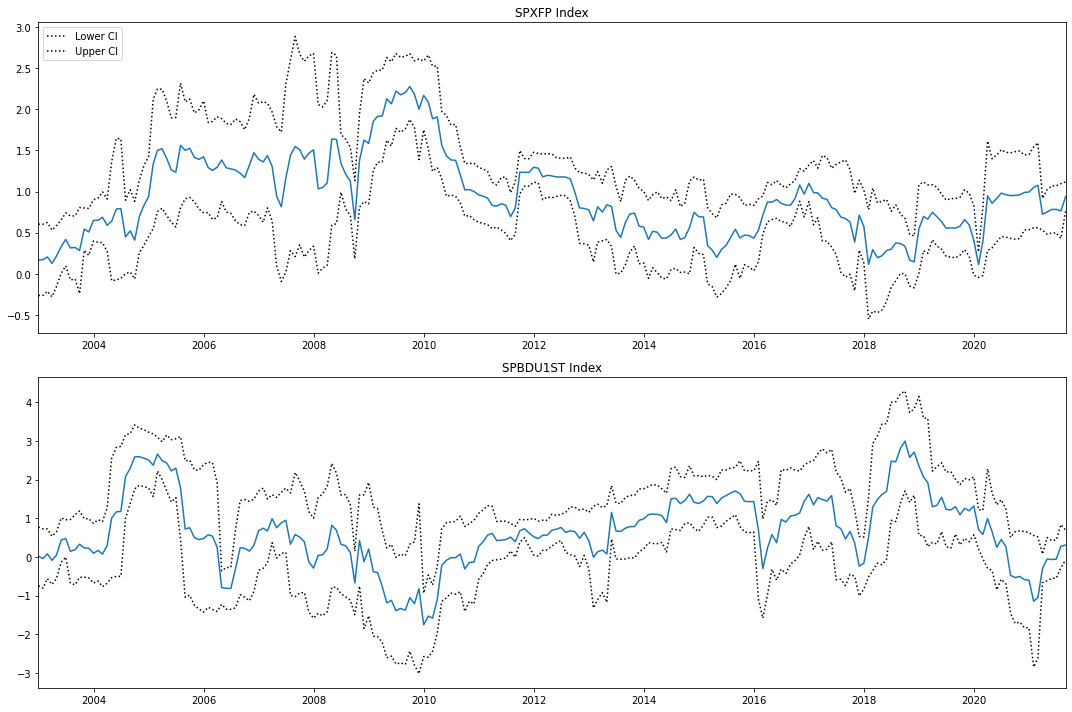

In [35]:
# Regression with S&P 500 and TIPS
model = RollingOLS(all_time_series['BBREIT Index'],
                   all_time_series[['SPXFP Index', 'SPBDU1ST Index']],
                   window=12).fit(cov_type='HAC',cov_kwds={'maxlags':3})
fig = model.plot_recursive_coefficient(figsize=(15,10))

<AxesSubplot:>

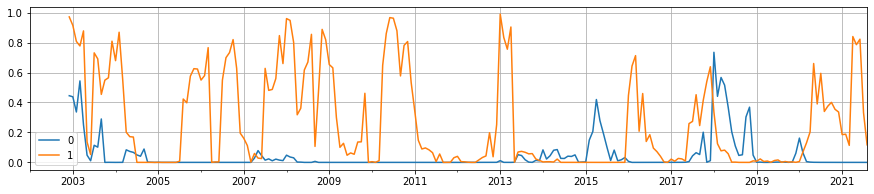

In [36]:
pd.DataFrame(model.pvalues, index=model.rsquared_adj.index).plot(figsize=(15,3), grid=True)

<AxesSubplot:>

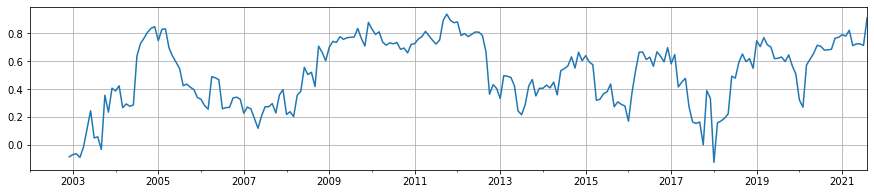

In [37]:
model.rsquared_adj.plot(figsize=(15,3), grid=True)

#### 36-month sliding window

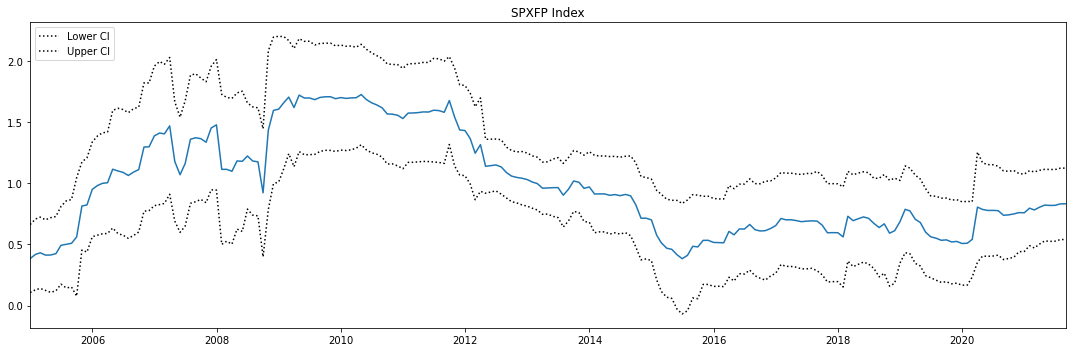

In [38]:
# Regression with only S&P 500
model = RollingOLS(all_time_series['BBREIT Index'],
                   all_time_series[['SPXFP Index']], window=36).fit(cov_type='HAC',cov_kwds={'maxlags':3})
fig = model.plot_recursive_coefficient(figsize=(15,5))

<AxesSubplot:>

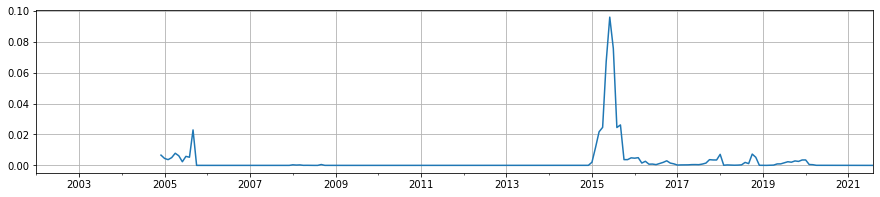

In [39]:
pd.Series([i[0] for i in list(model.pvalues)], index=model.rsquared_adj.index).plot(figsize=(15,3), grid=True)

<AxesSubplot:>

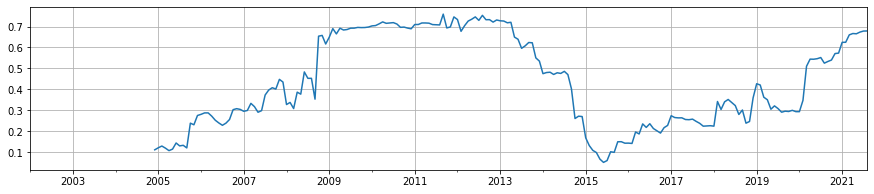

In [40]:
model.rsquared_adj.plot(figsize=(15,3), grid=True)

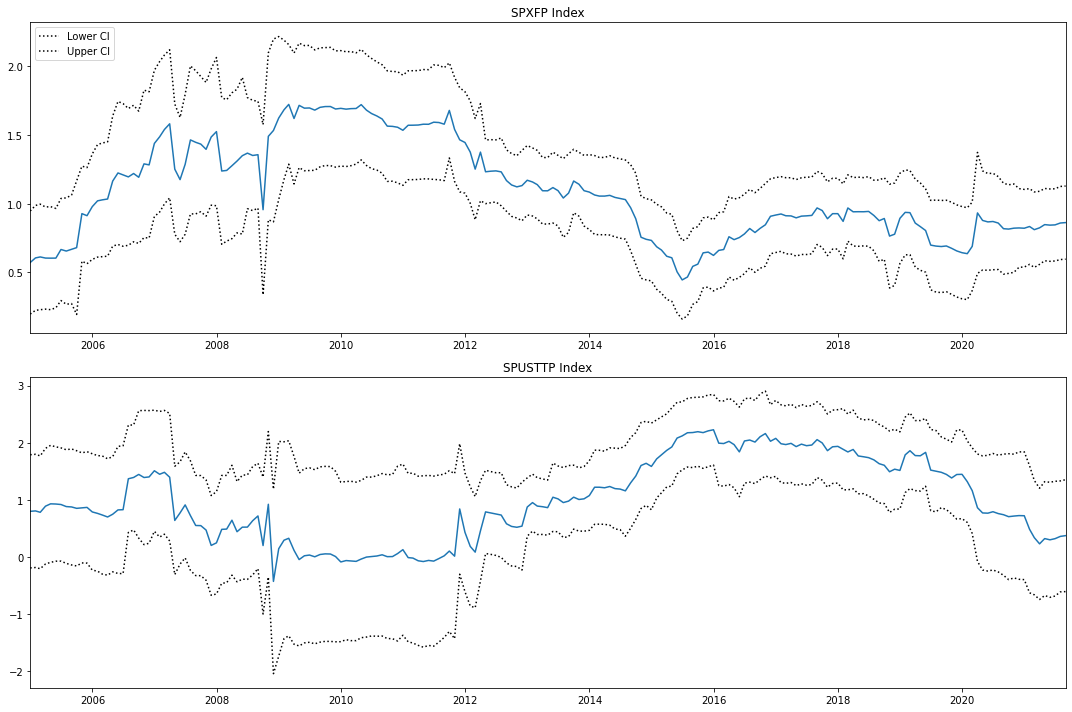

In [41]:
# Regression with S&P 500 and Treasury
model = RollingOLS(all_time_series['BBREIT Index'],
                   all_time_series[['SPXFP Index', 'SPUSTTP Index']],
                   window=36).fit(cov_type='HAC',cov_kwds={'maxlags':3})
fig = model.plot_recursive_coefficient(figsize=(15,10))

<AxesSubplot:>

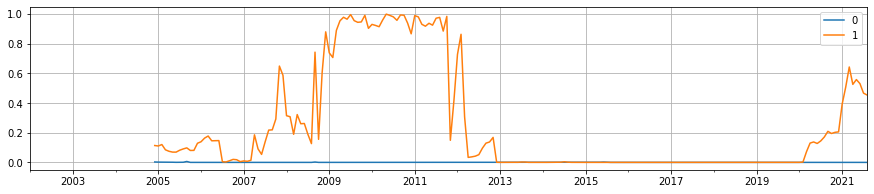

In [42]:
pd.DataFrame(model.pvalues, index=model.rsquared_adj.index).plot(figsize=(15,3), grid=True)

<AxesSubplot:>

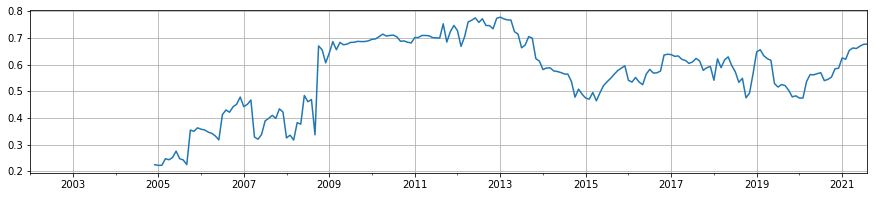

In [43]:
model.rsquared_adj.plot(figsize=(15,3), grid=True)

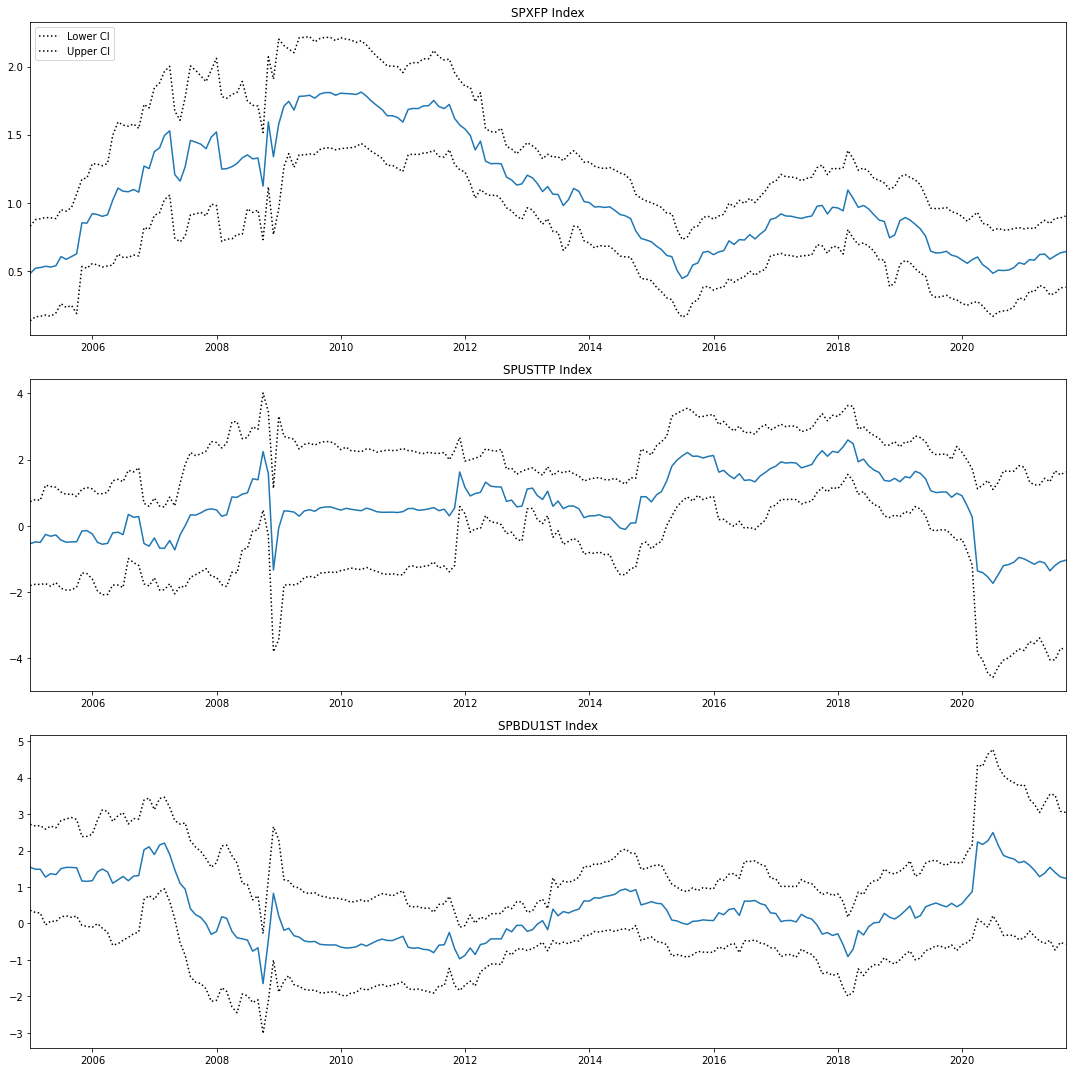

In [44]:
# Regression with S&P 500, Treasury and TIPS
model = RollingOLS(all_time_series['BBREIT Index'],
                   all_time_series[['SPXFP Index', 'SPUSTTP Index', 'SPBDU1ST Index']],
                   window=36).fit(cov_type='HAC',cov_kwds={'maxlags':3})
fig = model.plot_recursive_coefficient(figsize=(15,15))

<AxesSubplot:>

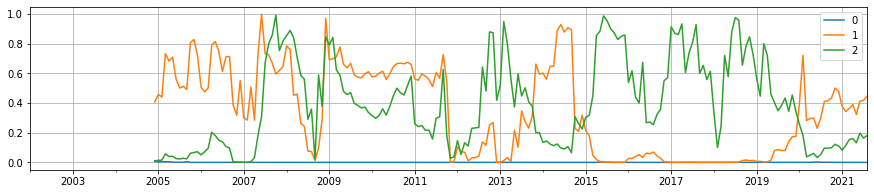

In [45]:
pd.DataFrame(model.pvalues, index=model.rsquared_adj.index).plot(figsize=(15,3), grid=True)

<AxesSubplot:>

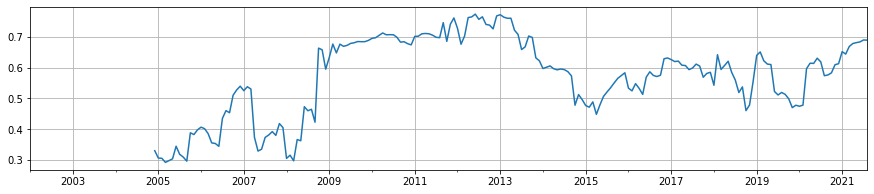

In [46]:
model.rsquared_adj.plot(figsize=(15,3), grid=True)

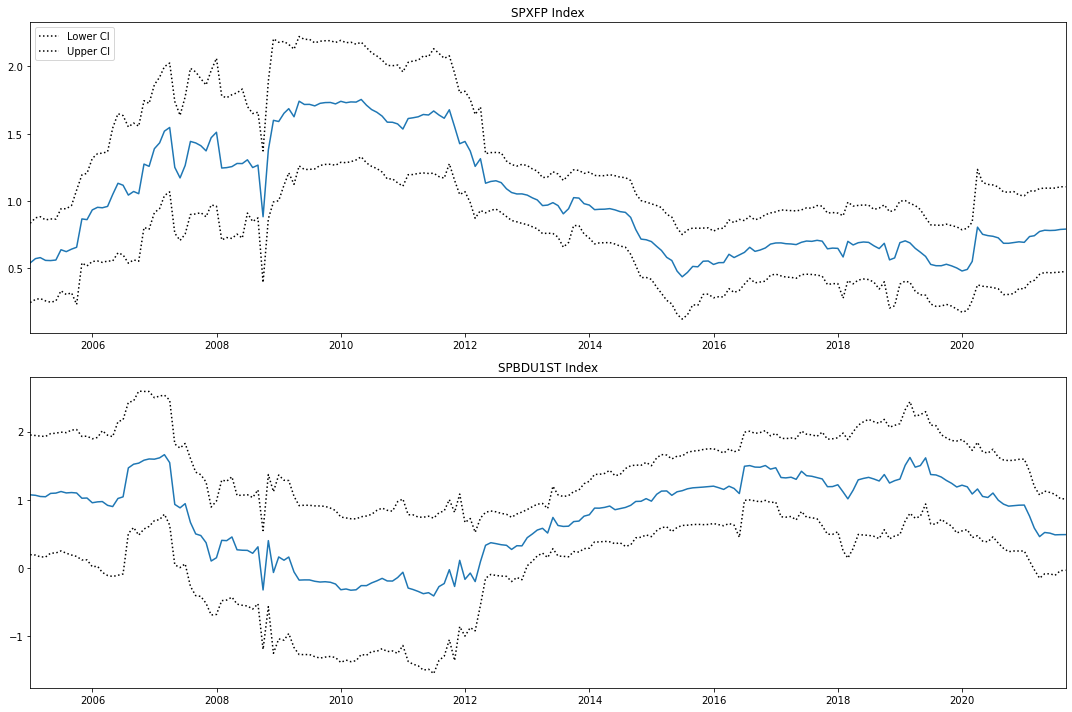

In [47]:
# Regression with S&P 500 and TIPS
model = RollingOLS(all_time_series['BBREIT Index'],
                   all_time_series[['SPXFP Index', 'SPBDU1ST Index']],
                   window=36).fit(cov_type='HAC',cov_kwds={'maxlags':3})
fig = model.plot_recursive_coefficient(figsize=(15,10))

<AxesSubplot:>

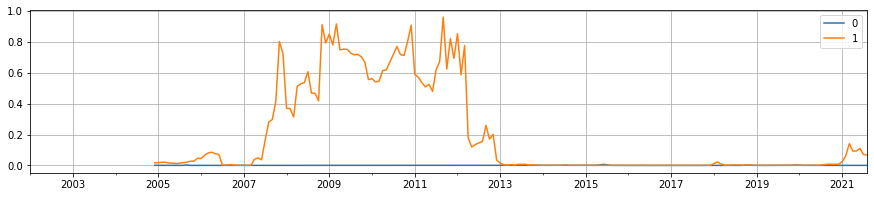

In [48]:
pd.DataFrame(model.pvalues, index=model.rsquared_adj.index).plot(figsize=(15,3), grid=True)

<AxesSubplot:>

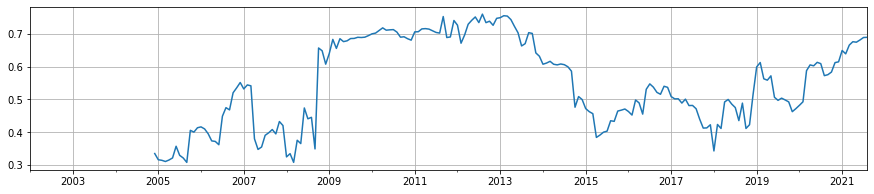

In [49]:
model.rsquared_adj.plot(figsize=(15,3), grid=True)

#### Rolling regressions with risk factors

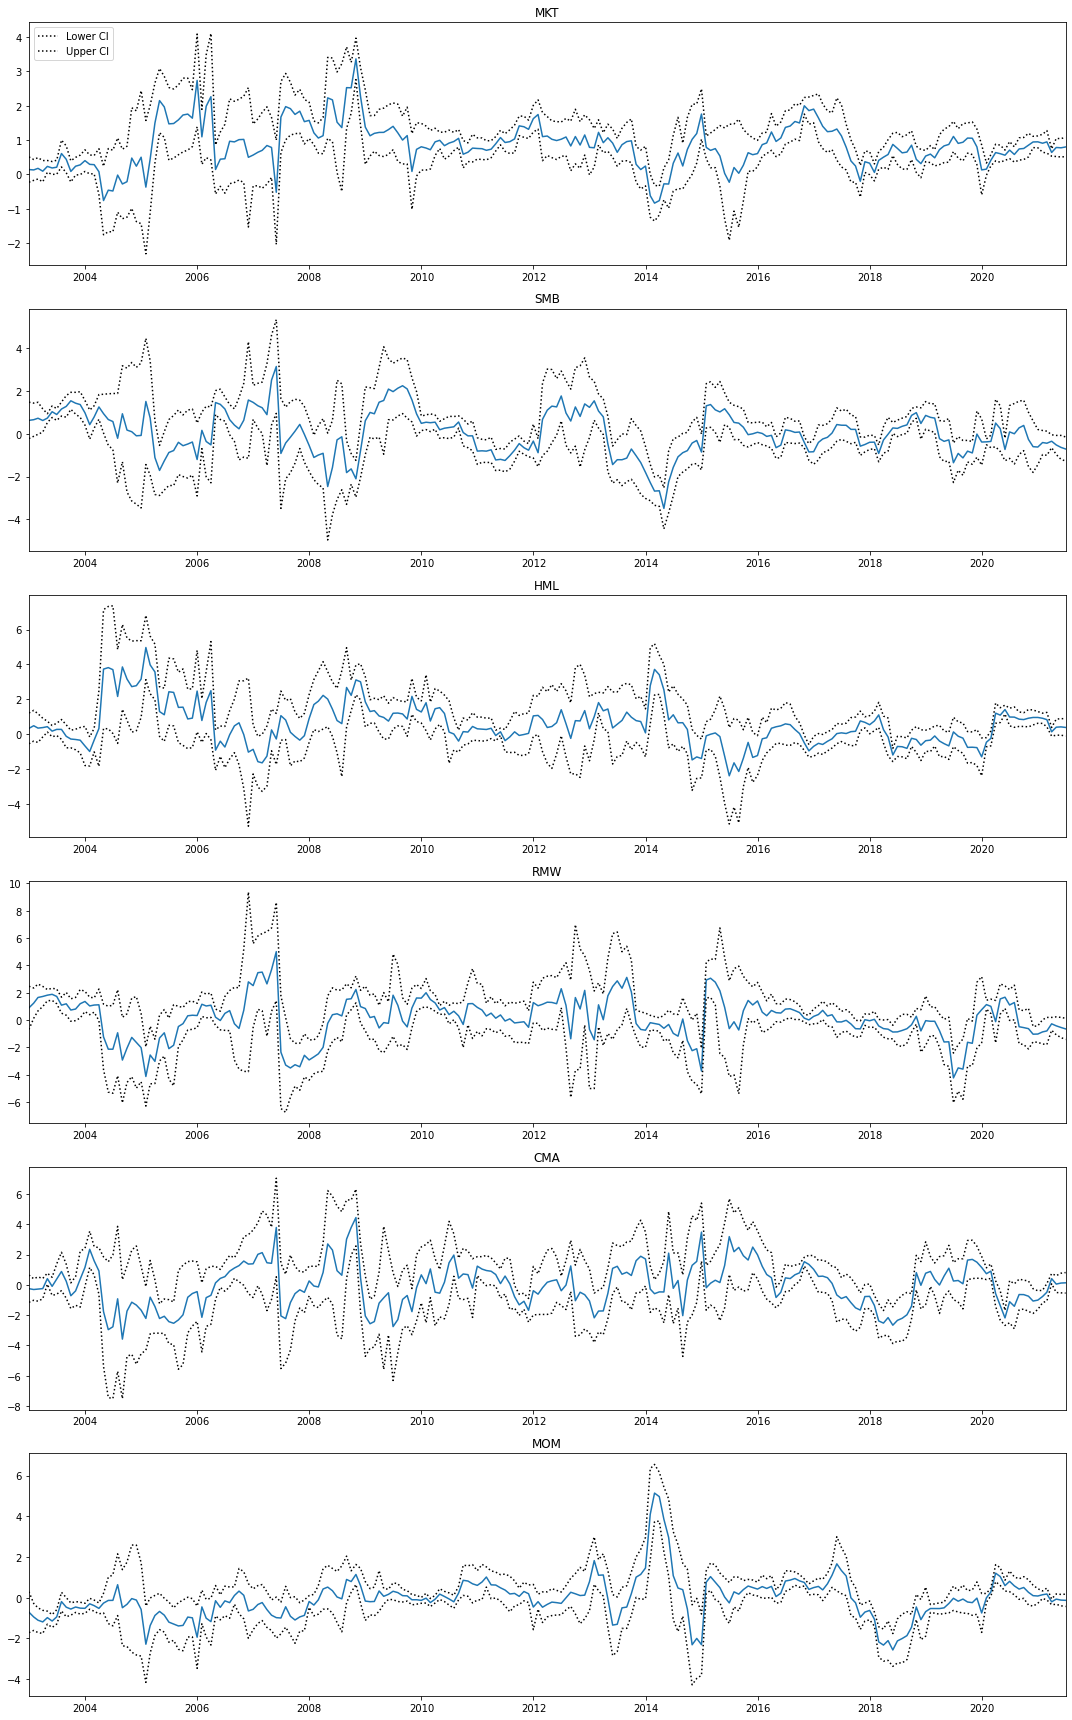

In [50]:
# Fama-French + Momentum factors (12-month sliding window)
model = RollingOLS(all_time_series_ff['BBREIT Index'],
                   all_time_series_ff[['MKT', 'SMB', 'HML', 'RMW', 'CMA', 'MOM']],
                   window=12).fit(cov_type='HAC',cov_kwds={'maxlags':3})
fig = model.plot_recursive_coefficient(figsize=(15,24))

<AxesSubplot:>

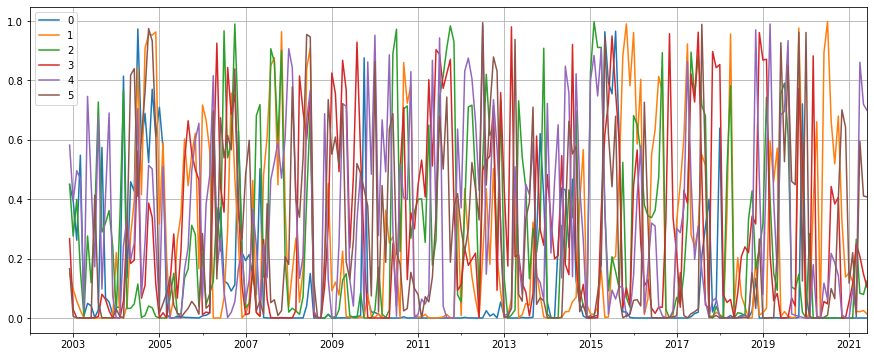

In [51]:
pd.DataFrame(model.pvalues, index=model.rsquared_adj.index).plot(figsize=(15,6), grid=True)

<AxesSubplot:>

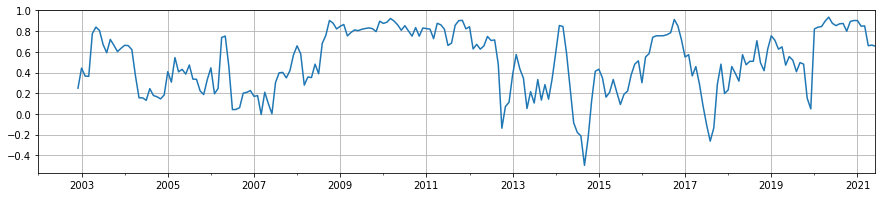

In [52]:
model.rsquared_adj.plot(figsize=(15,3), grid=True)

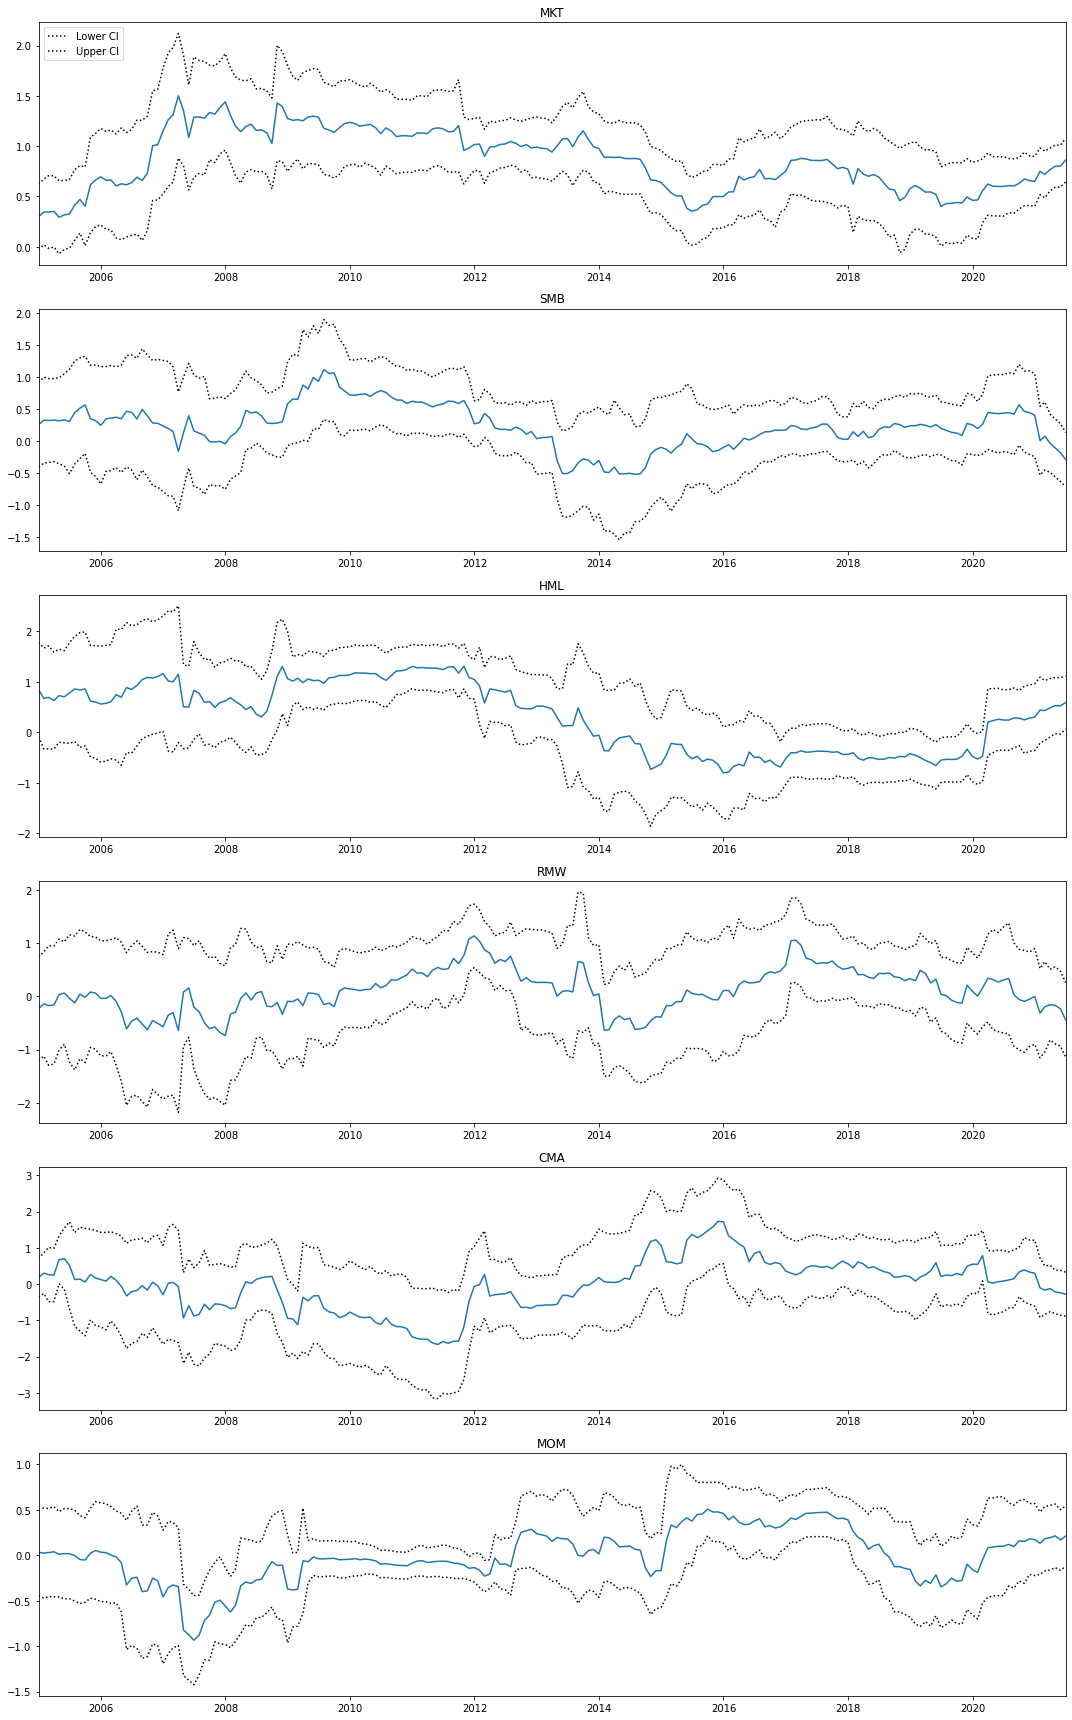

In [53]:
# Fama-French + Momentum factors (36-month sliding window)
model = RollingOLS(all_time_series_ff['BBREIT Index'],
                   all_time_series_ff[['MKT', 'SMB', 'HML', 'RMW', 'CMA', 'MOM']],
                   window=36).fit(cov_type='HAC',cov_kwds={'maxlags':3})
fig = model.plot_recursive_coefficient(figsize=(15,24))

<AxesSubplot:>

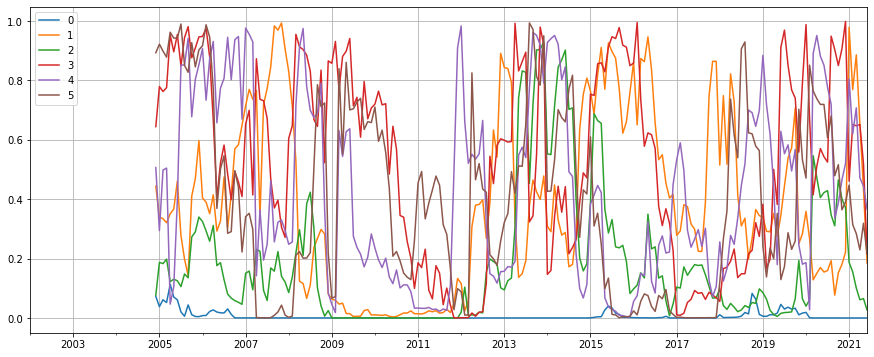

In [54]:
pd.DataFrame(model.pvalues, index=model.rsquared_adj.index).plot(figsize=(15,6), grid=True)

<AxesSubplot:>

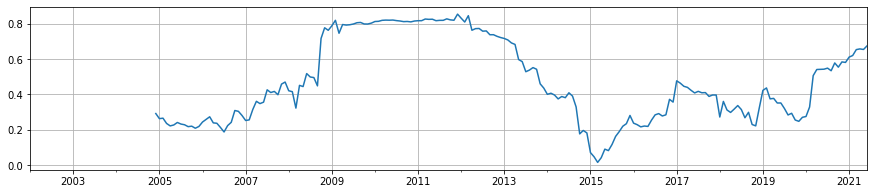

In [55]:
model.rsquared_adj.plot(figsize=(15,3), grid=True)

<AxesSubplot:>

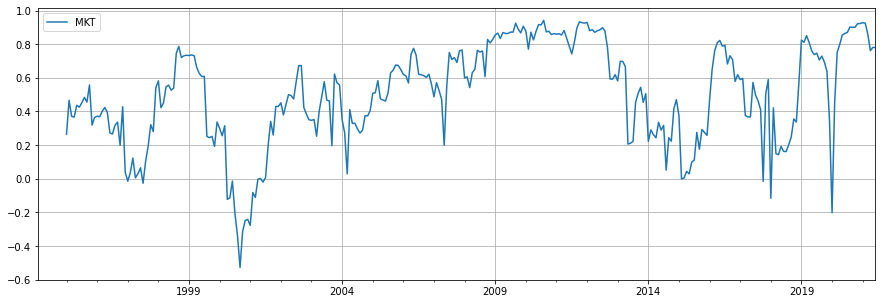

In [56]:
# Correlation between REITs and stocks over time
mkt_corr = monthly_data.iloc[:-2].copy()
mkt_corr.loc[:,'MKT'] = ff_factors.loc['199402':]['Mkt-RF'].values
corr = pd.DataFrame(
    {'MKT':mkt_corr[['BBREIT Index', 'MKT']].rolling(12).corr().xs('BBREIT Index', level=1, drop_level=False)['MKT'].values},
    index=mkt_corr[['BBREIT Index', 'MKT']].rolling(12).corr().xs('BBREIT Index', level=1, drop_level=False)['MKT'].index.get_level_values(0)
)
corr.plot(figsize=(15,5), grid=True)